# MiniProject 1: Clustering MNIST with Kohonen Maps

Our goal is to implement the Kohonen algorithm (or self-organizing map) and apply
it to a data set of hand-written digits. The advantage of the data set is that it is easy
to visualize, so that you can easily control the performance of the algorithm by visual
inspection.

In [15]:
import numpy as np
import scipy.spatial.distance as distm
import matplotlib.pylab as plb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set()
%matplotlib inline

### 1. Loading MNIST

In [2]:
# load in data and labels    
data = np.array(np.loadtxt('Resources/data.txt'))
labels = np.loadtxt('Resources/labels.txt')

Actually, we are not going to work with the 10 different digits from MNIST, only with 4 of them. They choice of digits is made by provided "name2digits" function that we define below. The name of choice four our experiment is "Dunai Vidit", an aggregation of our two names.

In [3]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('Resources/hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])

In [4]:
 # select 4 digits    
name = 'Dunai Vidit' # REPLACE BY YOUR OWN NAME
targetdigits = name2digits(name) # assign the four digits that should be used
print(targetdigits) # output the digits that were selected

[1 4 5 6]


C:\Users\dunay\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Next we filter our data by the given digits "1,4,5,6"

In [5]:
 # this selects all data vectors that corresponds to one of the four digits
data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
labels = labels[np.logical_or.reduce([labels==x for x in targetdigits])]
data, data_test, labels, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)

dy, dx = data.shape

### 2. Defining the functions

First the neighbouring function

In [6]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

For the iterative algorithm

In [7]:
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])

And finally for the kohonen parameter definition and main function

In [8]:
def kohonen_eta():
    
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    
    
    dim = 28*28
    data_range = 255.0
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6
    
    start = 0
    stop = -3
    eta_list = np.logspace(start,stop, 5)
    for j, eta in enumerate(eta_list):
        print(eta)

    
        #set the width of the neighborhood via the width of the gaussian that
        #describes it
        sigma = 3.0

        #initialise the centers randomly
        centers = np.random.rand(size_k**2, dim) * data_range

        #build a neighborhood matrix
        neighbor = np.arange(size_k**2).reshape((size_k, size_k))

        #set the learning rate
        # eta = 0.01 # HERE YOU HAVE TO SET YOUR OWN LEARNING RATE

        #set the maximal iteration count
        tmax = 6000 # this might or might not work; use your own convergence criterion

        #set the random order in which the datapoints should be presented
        i_random = np.arange(tmax) % dy
        np.random.shuffle(i_random)

        deltacenters = list()
        error = list()
        ini_centers = 0

        for t, i in enumerate(i_random):
            ini_centers = centers.copy()
            som_step(centers, data[i,:],neighbor,eta,sigma)
            deltacenters.append(np.mean(np.linalg.norm(ini_centers - centers, axis=1)))
            error.append(np.mean(np.linalg.norm(ini_centers - centers, axis=1))/eta)
            
        plb.subplot(len(eta_list),1,j+1)
        plb.plot(error)
    
'''

    # for visualization, you can use this:
    for i in range(size_k**2):
        plb.subplot(size_k,size_k,i+1)
        
        plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')
        
    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
    '''

"\n\n    # for visualization, you can use this:\n    for i in range(size_k**2):\n        plb.subplot(size_k,size_k,i+1)\n        \n        plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')\n        plb.axis('off')\n        \n    # leave the window open at the end of the loop\n    plb.show()\n    plb.draw()\n    "

In [9]:
def kohonen():
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    
    
    dim = 28*28
    data_range = 255.0
     
    #default values

    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = 0.7

    #set the learning rate
    eta = 0.03 # HERE YOU HAVE TO SET YOUR OWN LEARNING RATE

    #set the maximal iteration count
    tmax = 10000 # this might or might not work; use your own convergence criterion



    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6



    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range

#     #choose centers as one of the points
#     indx = np.arange(dy)
#     np.random.shuffle(indx)
#     indx = indx[0:36]
#     centers = data[indx,:]

    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))


    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)

    for t, i in enumerate(i_random):
        prev_centers =  centers
        som_step(centers, data[i,:],neighbor,eta,sigma)
        delta =  np.linalg.norm(centers - prev_centers,axis = 1)


    unit_label = labels[np.argmin(distm.cdist(centers,data),axis=1)]

    print(np.resize(unit_label,(size_k,size_k)))
    
    # for visualization, you can use this:
    for i in range(size_k**2):
        plb.subplot(size_k,size_k,i+1)
        plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')

    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
    
   
    labels_pred = unit_label[np.argmin(distm.cdist(data_test,centers),axis=1)]
    mean_accuracy = accuracy_score(labels_test,labels_pred)
    print("Mean Accuracy {}".format(mean_accuracy))

In [17]:
def kohonen_grid(l_sigma,l_size):
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    

    dim = 28*28
    data_range = 255.0
    mean_accuracy = np.empty([len(l_sigma),len(l_size)])
    
    for ii,sigma in enumerate(l_sigma):

        for jj,size_k in enumerate(l_size):
            print('Running for Sigma{}:{} and Unit Size{}:{}'.format(ii,sigma,jj,size_k))
            
            #default values

            #set the width of the neighborhood via the width of the gaussian that
            #describes it
        #     sigma = 0.7

            #set the learning rate
            eta = 0.03 # HERE YOU HAVE TO SET YOUR OWN LEARNING RATE

            #set the maximal iteration count
            tmax = 5000 # this might or might not work; use your own convergence criterion



            #set the size of the Kohonen map. In this case it will be 6 X 6
        #     size_k = 6



            #initialise the centers randomly
            centers = np.random.rand(size_k**2, dim) * data_range

        #     #choose centers as one of the points
        #     indx = np.arange(dy)
        #     np.random.shuffle(indx)
        #     indx = indx[0:36]
        #     centers = data[indx,:]

            #build a neighborhood matrix
            neighbor = np.arange(size_k**2).reshape((size_k, size_k))


            #set the random order in which the datapoints should be presented
            i_random = np.arange(tmax) % dy
            np.random.shuffle(i_random)

            for t, i in enumerate(i_random):
                prev_centers =  centers
                som_step(centers, data[i,:],neighbor,eta,sigma)
                delta =  np.linalg.norm(centers - prev_centers,axis = 1)


            unit_label = labels[np.argmin(distm.cdist(centers,data),axis=1)]
            labels_pred = unit_label[np.argmin(distm.cdist(data_test,centers),axis=1)]
            mean_accuracy[ii,jj] = accuracy_score(labels_test,labels_pred)
    
    print(mean_accuracy)
    return mean_accuracy
    
    
            
            
            
            

#     print(np.resize(unit_label,(size_k,size_k)))
    
#     # for visualization, you can use this:
#     for i in range(size_k**2):
#         plb.subplot(size_k,size_k,i+1)
#         plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
#         plb.axis('off')

#     # leave the window open at the end of the loop
#     plb.show()
#     plb.draw()
    
       #labels_pred = unit_label[np.argmin(distm.cdist(data_test,centers),axis=1)]
#     mean_accuracy = accuracy_score(labels_test,labels_pred)
#     print("Mean Accuracy {}".format(mean_accuracy))

### 3. Running

Running for Sigma0:0.1 and Unit Size0:6
Running for Sigma0:0.1 and Unit Size1:7
Running for Sigma0:0.1 and Unit Size2:8
Running for Sigma0:0.1 and Unit Size3:9
Running for Sigma0:0.1 and Unit Size4:10
Running for Sigma1:0.5 and Unit Size0:6
Running for Sigma1:0.5 and Unit Size1:7
Running for Sigma1:0.5 and Unit Size2:8
Running for Sigma1:0.5 and Unit Size3:9
Running for Sigma1:0.5 and Unit Size4:10
Running for Sigma2:1 and Unit Size0:6
Running for Sigma2:1 and Unit Size1:7
Running for Sigma2:1 and Unit Size2:8
Running for Sigma2:1 and Unit Size3:9
Running for Sigma2:1 and Unit Size4:10
Running for Sigma3:3 and Unit Size0:6
Running for Sigma3:3 and Unit Size1:7
Running for Sigma3:3 and Unit Size2:8
Running for Sigma3:3 and Unit Size3:9
Running for Sigma3:3 and Unit Size4:10
Running for Sigma4:5 and Unit Size0:6
Running for Sigma4:5 and Unit Size1:7
Running for Sigma4:5 and Unit Size2:8
Running for Sigma4:5 and Unit Size3:9
Running for Sigma4:5 and Unit Size4:10
Running for Sigma5:9 and 

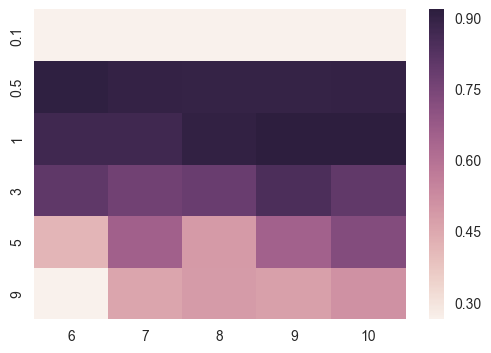

In [19]:
l_sigma = [0.1,0.5,1,3,5,9]
l_size = [6,7,8,9,10]

mean_accuracy = kohonen_grid(l_sigma,l_size)
ax = sns.heatmap(mean_accuracy,xticklabels=l_size,yticklabels=l_sigma)

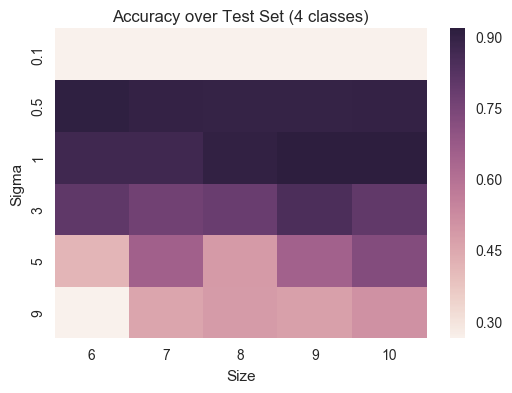

In [24]:
ax = sns.heatmap(mean_accuracy,xticklabels=l_size,yticklabels=l_sigma)
ax.set_ylabel('Sigma')
ax.set_xlabel('Size')
ax.set_title('Accuracy over Test Set (4 classes)')

In [23]:
ax.set_ylabel('Sigma')
ax.set_xlabel('Size')
ax.set_title('Accuracy over Test Set (4 classes)')

In [44]:
def kohonen_decay():
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    
    
    dim = 28*28
    data_range = 255.0
     
    #default values

    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma0 = 20

    #set the learning rate
    eta = 0.03 # HERE YOU HAVE TO SET YOUR OWN LEARNING RATE

    #set the maximal iteration count
    tmax = 5000 # this might or might not work; use your own convergence criterion



    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 9



    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    

    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))


    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    sigma_learning = 0.1
    
    for t, i in enumerate(i_random):
        prev_centers =  centers
        sigma = sigma0-t*(sigma0/tmax)
        som_step(centers, data[i,:],neighbor,eta,sigma)
        delta =  np.linalg.norm(centers - prev_centers,axis = 1)
        
        if t%100 == 0:
            print(sigma)


    unit_label = labels[np.argmin(distm.cdist(centers,data),axis=1)]

    print(np.resize(unit_label,(size_k,size_k)))
    
    # for visualization, you can use this:
    for i in range(size_k**2):
        plb.subplot(size_k,size_k,i+1)
        plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')

    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
    
   
    labels_pred = unit_label[np.argmin(distm.cdist(data_test,centers),axis=1)]
    mean_accuracy = accuracy_score(labels_test,labels_pred)
    print("Mean Accuracy {}".format(mean_accuracy))

20.0
19.6
19.2
18.8
18.4
18.0
17.6
17.2
16.8
16.4
16.0
15.6
15.2
14.8
14.399999999999999
14.0
13.6
13.2
12.8
12.399999999999999
12.0
11.6
11.2
10.799999999999999
10.4
10.0
9.6
9.2
8.799999999999999
8.4
8.0
7.6
7.199999999999999
6.799999999999999
6.4
6.0
5.6
5.199999999999999
4.799999999999999
4.4
4.0
3.6000000000000014
3.1999999999999993
2.8000000000000007
2.3999999999999986
2.0
1.5999999999999979
1.1999999999999993
0.8000000000000007
0.3999999999999986
[[ 6.  6.  6.  6.  1.  1.  1.  1.  1.]
 [ 6.  6.  6.  6.  1.  1.  1.  1.  1.]
 [ 6.  6.  5.  5.  5.  1.  1.  1.  1.]
 [ 6.  5.  5.  5.  5.  1.  1.  1.  1.]
 [ 5.  5.  5.  5.  5.  5.  1.  1.  1.]
 [ 5.  5.  5.  5.  4.  4.  4.  4.  4.]
 [ 5.  6.  4.  4.  4.  4.  4.  4.  4.]
 [ 6.  6.  4.  4.  4.  4.  4.  4.  4.]
 [ 6.  6.  4.  4.  4.  4.  4.  4.  4.]]


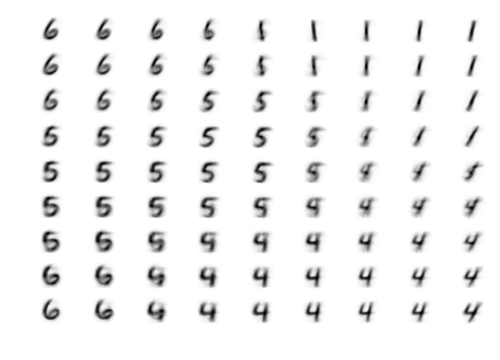

Mean Accuracy 0.9025


In [45]:
kohonen_decay()